# proj1 — Colorizing the Prokudin-Gorskii Photo Collection

The goal of this assignment is to take the digitized Prokudin-Gorskii glass plate images and, using image processing techniques, automatically produce a color image with as few visual artifacts as possible. To do this, we extract the three color channel images, place them on top of each other, and align them so that they form a single RGB color image.

Note that the filter order for these images is BGR from top to bottom!

### Single-Scale Implementation: Trying Out All Possible Displacements
The easiest way to align the parts is to 
1. Exhaustively search over a window of possible displacements (say [-15,15] pixels), 
2. Score each one using some image matching metric, 
3. Take the displacement with the best score. 

We use the L2 norm and the Normalized Cross Correlation as alignment metrics for the single-scale implementation.

In [ ]:
import numpy as np
import skimage as sk
import skimage.io as skio

def get_channels(input_img):
    im = skio.imread(input_img)

    im = sk.img_as_float(im)
        
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    return b, g, r


def euclidean_metric(im1, im2):
    return np.sqrt(np.sum((im1 - im2)**2))


def ncc_metric(im1, im2):
    im1_vec, im2_vec = im1.flatten(), im2.flatten()
    im1_mag, im2_mag = np.linalg.norm(im1_vec), np.linalg.norm(im2_vec)
    if im1_mag == 0 or im2_mag == 0:
        return 0 
    else:  
        return np.dot(im1_vec/im1_mag, im2_vec/im2_mag)
    
def zncc_metric(im1, im2):
    a = im1.astype(np.float32).ravel()
    b = im2.astype(np.float32).ravel()
    a = a - a.mean()
    b = b - b.mean()
    na = np.linalg.norm(a); nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


def align_and_stack(im1, im2, im3, metric='euclidean', alignment_ch='blue', disp_window=[-15,15]):
    # Swap top image (blue) to change alignment channel to green/red
    if alignment_ch == 'green':
        im1_temp = im1
        im1 = im2
        im2 = im1_temp

    elif alignment_ch == 'red':
        im1_temp = im1
        im1 = im3
        im3 = im1_temp

    # Align second and third images to top image
    im2, shift_im2 = align(im1, im2, metric, disp_window)
    im3, shift_im3 = align(im1, im3, metric, disp_window)

    if alignment_ch == 'green':
        im2_temp = im2
        im2 = im1
        im1 = im2_temp

    if alignment_ch == 'red':
        im3_temp = im3
        im3 = im1
        im1 = im3_temp
        
    return np.dstack([im3, im2, im1]), shift_im2, shift_im3

def align(im1, im2, metric, disp_window):
    best = np.inf if metric == 'euclidean' else -np.inf
    shift = [0, 0]

    for dx in range(disp_window[0], disp_window[-1] + 1):
        for dy in range(disp_window[0], disp_window[-1] + 1):
            im2_r = np.roll(im2, (dx, dy), axis=(0,1))

            if metric == 'euclidean':
                err = euclidean_metric(im1, im2_r)
                if err < best:
                    shift = [dx, dy]
                    best = err

            elif metric == 'ncc':
                err = ncc_metric(im1, im2_r)
                if err > best:
                    shift = [dx, dy]
                    best = err
                
            elif metric == 'zncc':
                err = zncc_metric(im1, im2_r)
                if err > best:
                    shift = [dx, dy]
                    best = err

    res = np.roll(im2, shift=(shift[0], shift[1]), axis=(0, 1))
    return res, shift

In [15]:
import numpy as np
import skimage as sk
import skimage.io as skio

# ---------------------------
# I/O
# ---------------------------
def get_channels(input_img):
    im = skio.imread(input_img)
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels (top=blue, mid=green, bottom=red)
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]
    return b, g, r

# ---------------------------
# Metrics
# ---------------------------
def euclidean_metric(im1, im2):
    """Classic L2 (not used by the aligner, which uses SSD directly)."""
    diff = im1.astype(np.float32) - im2.astype(np.float32)
    return float(np.sqrt(np.sum(diff * diff)))

def ncc_metric(im1, im2):
    """Cosine similarity; sensitive to brightness offset."""
    a = im1.astype(np.float32).ravel()
    b = im2.astype(np.float32).ravel()
    na = np.linalg.norm(a); nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a / na, b / nb))

def zncc_metric(im1, im2):
    """Zero-mean normalized cross-correlation; robust to brightness offset."""
    a = im1.astype(np.float32).ravel()
    b = im2.astype(np.float32).ravel()
    a = a - a.mean()
    b = b - b.mean()
    na = np.linalg.norm(a); nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

# ---------------------------
# Masks (border + no-wrap)
# ---------------------------
def _central_mask(shape, frac=0.15, min_px=1):
    """
    True only in the central box after cropping a 'frac' border on all sides.
    If frac==0, use all pixels.
    """
    H, W = shape[:2]
    if frac <= 0:
        return np.ones((H, W), dtype=bool)
    by = max(min_px, int(frac * H))
    bx = max(min_px, int(frac * W))
    m = np.zeros((H, W), dtype=bool)
    if (H - 2*by) > 0 and (W - 2*bx) > 0:
        m[by:H-by, bx:W-bx] = True
    return m

def _valid_mask(shape, dy, dx):
    """
    Mask that removes wrapped bands introduced by np.roll(dy, dx).
    True = valid overlap (not wrapped).
    """
    H, W = shape[:2]
    m = np.ones((H, W), dtype=bool)
    if dy > 0:  m[:dy, :] = False       # top wrapped-in
    if dy < 0:  m[dy:, :] = False       # bottom wrapped-in
    if dx > 0:  m[:, :dx] = False       # left wrapped-in
    if dx < 0:  m[:, dx:] = False       # right wrapped-in
    return m

# ---------------------------
# Alignment core
# ---------------------------
def align(im1, im2, metric, disp_window, margin_frac=0.0):
    """
    Exhaustive search over integer (dy, dx) in disp_window.
    Scores only the central region (margin_frac cropped) and ignores roll-wrapped bands.
    For 'euclidean', minimizes SSD on the valid region (no sqrt).
    Returns: (aligned_im2, [dy, dx])
    """
    best = np.inf if metric == 'euclidean' else -np.inf
    shift = [0, 0]

    # Precompute central mask (15% for low-res if requested; all-True if margin_frac==0)
    base_mask = _central_mask(im1.shape, frac=margin_frac)

    lo, hi = disp_window[0], disp_window[-1]
    for dy in range(lo, hi + 1):          # rows (axis=0)
        for dx in range(lo, hi + 1):      # cols (axis=1)
            im2_r = np.roll(im2, shift=(dy, dx), axis=(0, 1))
            # combine central crop with valid (no-wrap) mask
            mask = base_mask & _valid_mask(im1.shape, dy, dx)
            if mask.sum() == 0:
                continue

            if metric == 'euclidean':
                # SSD on overlap only
                diff = (im1 - im2_r)[mask].astype(np.float32)
                err = float(np.sum(diff * diff))  # minimize
                if err < best:
                    best = err; shift = [dy, dx]

            elif metric == 'ncc':
                a = im1[mask].astype(np.float32); b = im2_r[mask].astype(np.float32)
                na = np.linalg.norm(a); nb = np.linalg.norm(b)
                err = 0.0 if (na == 0 or nb == 0) else float(np.dot(a/na, b/nb))  # maximize
                if err > best:
                    best = err; shift = [dy, dx]

            elif metric == 'zncc':
                a = im1[mask].astype(np.float32); b = im2_r[mask].astype(np.float32)
                a = a - a.mean(); b = b - b.mean()
                na = np.linalg.norm(a); nb = np.linalg.norm(b)
                err = 0.0 if (na == 0 or nb == 0) else float(np.dot(a, b) / (na * nb))  # maximize
                if err > best:
                    best = err; shift = [dy, dx]

            else:
                raise ValueError("metric must be one of {'euclidean','ncc','zncc'}")

    res = np.roll(im2, shift=(shift[0], shift[1]), axis=(0, 1))
    return res, shift

# ---------------------------
# Driver that keeps output order = RGB, regardless of reference
# ---------------------------
def align_and_stack(im1, im2, im3, metric='euclidean', alignment_ch='blue', disp_window=[-15,15]):
    """
    im1, im2, im3 are the blue, green, red plates in that order (as returned by get_channels).
    Aligns G and R to the chosen reference ('blue' by default), then returns an RGB image (R,G,B).
    For low-res images (width <= 500 px), a 15% border margin is ignored during scoring.
    """
    # Choose margin only for low-res (≤ 500 px wide)
    width = im1.shape[1]
    margin_frac = 0.15 if width <= 500 else 0.0

    # Map reference
    # im1=b, im2=g, im3=r by convention from get_channels
    ref = {'blue': im1, 'green': im2, 'red': im3}[alignment_ch]

    if alignment_ch == 'blue':
        g_aligned, shift_g = align(ref, im2, metric, disp_window, margin_frac=margin_frac)
        r_aligned, shift_r = align(ref, im3, metric, disp_window, margin_frac=margin_frac)
        rgb = np.dstack([r_aligned, g_aligned, ref])
        shifts = {'g': shift_g, 'r': shift_r}

    elif alignment_ch == 'green':
        b_aligned, shift_b = align(ref, im1, metric, disp_window, margin_frac=margin_frac)
        r_aligned, shift_r = align(ref, im3, metric, disp_window, margin_frac=margin_frac)
        rgb = np.dstack([r_aligned, ref, b_aligned])
        shifts = {'b': shift_b, 'r': shift_r}

    else:  # 'red'
        b_aligned, shift_b = align(ref, im1, metric, disp_window, margin_frac=margin_frac)
        g_aligned, shift_g = align(ref, im2, metric, disp_window, margin_frac=margin_frac)
        rgb = np.dstack([ref, g_aligned, b_aligned])
        shifts = {'b': shift_b, 'g': shift_g}

    return rgb, shifts


In [16]:
imfolder = './media/'
imname = 'cathedral.jpg'
b, g, r = get_channels(imfolder + imname)

# Minimize SSD with 15% margin for low-res:
colorized_b, shifts_b = align_and_stack(b, g, r, alignment_ch='blue', metric='euclidean')
colorized_g, shifts_g = align_and_stack(b, g, r, alignment_ch='green', metric='euclidean')
colorized_r, shifts_r = align_and_stack(b, g, r, alignment_ch='red', metric='euclidean')

print("blue shifts", shifts_b)
print("green shifts", shifts_g)
print("red shifts", shifts_r)


blue shifts {'g': [5, 2], 'r': [12, 3]}
green shifts {'b': [-5, -2], 'r': [7, 1]}
red shifts {'b': [-12, -3], 'g': [-7, -1]}


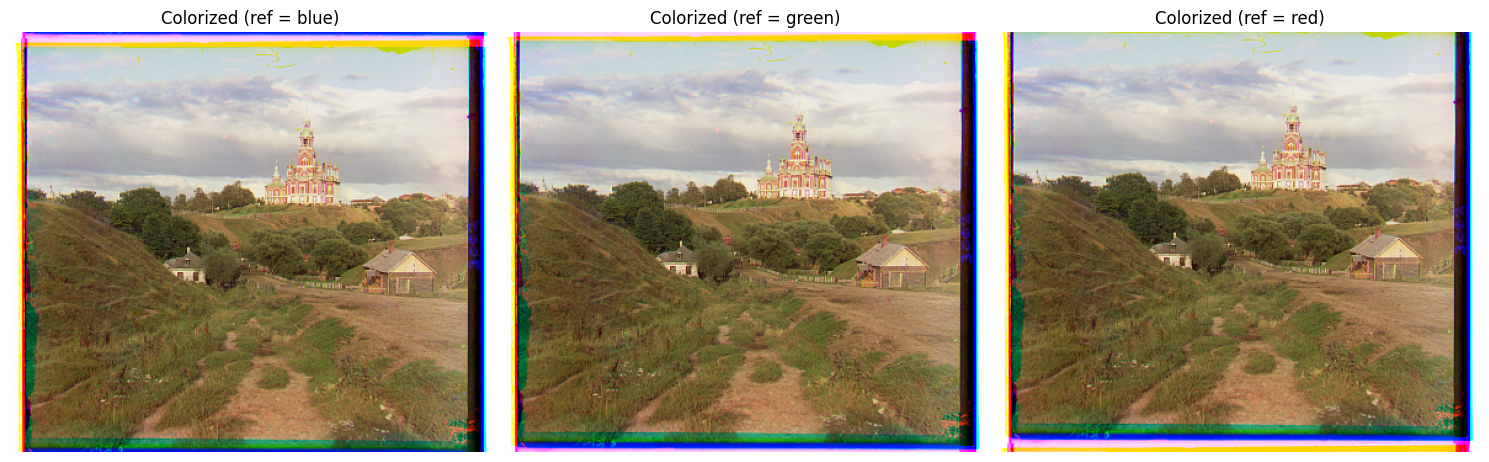

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
imgs = [colorized_b, colorized_g, colorized_r]
titles = ["Colorized (ref = blue)", "Colorized (ref = green)", "Colorized (ref = red)"]

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Multi-Scale Pyramid Implementation: Trying Out All Possible Displacements

In [18]:
# --- NEW: robust score image = gradient magnitude ---
def _grad_mag(im):
    im = im.astype(np.float32)
    gy, gx = np.gradient(im)
    return np.hypot(gx, gy)

# (tweak) margin chosen against the *smaller* dimension so it’s not too tiny
def _choose_margin_frac(shape, disp_window, min_frac=0.10, max_frac=0.25, safety_px=4):
    H, W = shape[:2]
    max_disp = max(abs(disp_window[0]), abs(disp_window[-1]))
    margin_px = max_disp + safety_px
    frac = margin_px / float(min(H, W))   # was max(H,W) before; this yields a safer crop
    return float(np.clip(frac, min_frac, max_frac))

# (tweak) allow bigger shifts on huge plates
def _auto_max_disp(shape, base_min=40, frac=0.12, cap=900):
    H, W = shape[:2]
    guess = int(max(base_min, frac * min(H, W)))
    return int(min(guess, cap))
def _align_window(im1, im2, metric, cy, cx, radius, margin_frac=0.0, score='grad'):
    """
    Search (dy, dx) in [cy-radius, cy+radius] × [cx-radius, cx+radius].
    `score`: 'grad' (default) or 'raw' – only affects scoring, not the returned image.
    """
    # Build score images once (rolling them is cheap & equivalent to roll-then-gradient)
    A = _grad_mag(im1) if score == 'grad' else im1.astype(np.float32)
    B = _grad_mag(im2) if score == 'grad' else im2.astype(np.float32)

    best = np.inf if metric == 'euclidean' else -np.inf
    shift = [cy, cx]
    base_mask = _central_mask(im1.shape, frac=margin_frac)

    y_lo, y_hi = int(np.floor(cy - radius)), int(np.ceil(cy + radius))
    x_lo, x_hi = int(np.floor(cx - radius)), int(np.ceil(cx + radius))

    for dy in range(y_lo, y_hi + 1):
        for dx in range(x_lo, x_hi + 1):
            Br = np.roll(B, shift=(dy, dx), axis=(0, 1))
            mask = base_mask & _valid_mask(im1.shape, dy, dx)
            n = mask.sum()
            if n == 0:
                continue

            if metric == 'euclidean':         # SSD on score images
                diff = (A - Br)[mask]
                err  = float(np.sum(diff * diff))
                if err < best:
                    best, shift = err, [dy, dx]

            elif metric == 'ncc':             # cosine
                a = A[mask]; b = Br[mask]
                na = np.linalg.norm(a); nb = np.linalg.norm(b)
                err = 0.0 if (na == 0 or nb == 0) else float(np.dot(a/na, b/nb))
                if err > best:
                    best, shift = err, [dy, dx]

            elif metric == 'zncc':            # zero-mean cosine
                a = A[mask] - A[mask].mean()
                b = Br[mask] - Br[mask].mean()
                na = np.linalg.norm(a); nb = np.linalg.norm(b)
                err = 0.0 if (na == 0 or nb == 0) else float(np.dot(a, b) / (na * nb))
                if err > best:
                    best, shift = err, [dy, dx]
            else:
                raise ValueError("metric must be one of {'euclidean','ncc','zncc'}")

    # Apply the best shift to the ORIGINAL im2 for output
    res = np.roll(im2, shift=(shift[0], shift[1]), axis=(0, 1))
    return res, shift



def align_pyramid(im1, im2, metric='euclidean', base_window=None,
                  scale=0.5, min_size=256, max_levels=7, refine_radius=8,
                  margin_frac=None, score='grad'):
    if base_window is None:
        max_disp   = _auto_max_disp(im1.shape)     # larger, adaptive
        base_window = (-max_disp, max_disp)
    base_radius = max(abs(base_window[0]), abs(base_window[-1]))

    if margin_frac is None:
        margin_frac = _choose_margin_frac(im1.shape, base_window)

    pyr1 = _build_pyramid(im1, scale=scale, min_size=min_size, max_levels=max_levels)
    pyr2 = _build_pyramid(im2, scale=scale, min_size=min_size, max_levels=max_levels)
    L = min(len(pyr1), len(pyr2)); pyr1 = pyr1[:L]; pyr2 = pyr2[:L]
    k = L - 1

    coarse_radius = max(1, int(np.ceil(base_radius * (scale ** k))))
    _, shift_k = _align_window(pyr1[k], pyr2[k], metric, cy=0, cx=0,
                               radius=coarse_radius, margin_frac=margin_frac, score=score)

    for level in range(k - 1, -1, -1):
        guess_y = int(round(shift_k[0] / scale))
        guess_x = int(round(shift_k[1] / scale))
        _, shift_k = _align_window(pyr1[level], pyr2[level], metric,
                                   cy=guess_y, cx=guess_x,
                                   radius=max(3, refine_radius),
                                   margin_frac=margin_frac, score=score)

    aligned = np.roll(im2, shift=(shift_k[0], shift_k[1]), axis=(0, 1))
    return aligned, shift_k


def align_and_stack_pyramid(b, g, r, metric='euclidean', alignment_ch='blue',
                            base_window=None, scale=0.5, min_size=256,
                            max_levels=7, refine_radius=8, score='grad'):
    ref_map = {'blue': b, 'green': g, 'red': r}
    ref = ref_map[alignment_ch]

    if alignment_ch == 'blue':
        g_aligned, s_g = align_pyramid(ref, g, metric, base_window, scale, min_size, max_levels, refine_radius, score=score)
        r_aligned, s_r = align_pyramid(ref, r, metric, base_window, scale, min_size, max_levels, refine_radius, score=score)
        rgb = np.dstack([r_aligned, g_aligned, ref]); shifts = {'g': s_g, 'r': s_r}
    elif alignment_ch == 'green':
        b_aligned, s_b = align_pyramid(ref, b, metric, base_window, scale, min_size, max_levels, refine_radius, score=score)
        r_aligned, s_r = align_pyramid(ref, r, metric, base_window, scale, min_size, max_levels, refine_radius, score=score)
        rgb = np.dstack([r_aligned, ref, b_aligned]); shifts = {'b': s_b, 'r': s_r}
    else:
        b_aligned, s_b = align_pyramid(ref, b, metric, base_window, scale, min_size, max_levels, refine_radius, score=score)
        g_aligned, s_g = align_pyramid(ref, g, metric, base_window, scale, min_size, max_levels, refine_radius, score=score)
        rgb = np.dstack([ref, g_aligned, b_aligned]); shifts = {'b': s_b, 'g': s_g}

    return rgb, shifts


In [19]:
imfolder = './media/'
imname = 'church.tif'  # or any large scan

b, g, r = get_channels(imfolder + imname)

# SSD (euclidean) is minimized; for brightness robustness use metric='zncc'
rgb, shifts = align_and_stack_pyramid(b, g, r, metric='zncc', alignment_ch='blue', score='grad')


print(shifts)


NameError: name '_build_pyramid' is not defined

In [ ]:
skio.imshow(rgb)

NameError: name 'rgb' is not defined

C:\Users\skofm\AppData\Local\Temp\ipykernel_22636\2635582012.py:16: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(out)


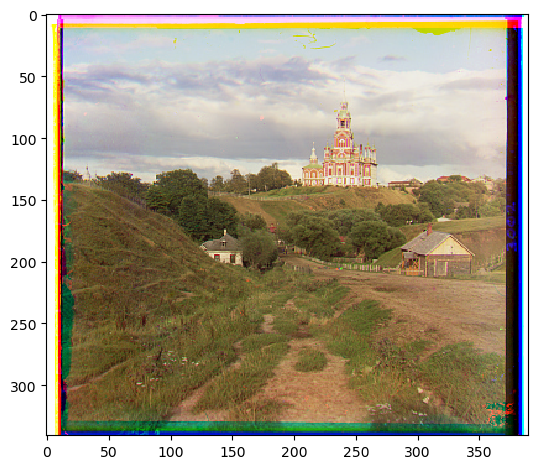

In [65]:
im = skio.imread(imfolder + imname)
im = sk.img_as_float(im)
    
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g_raw = im[height: 2*height]
r_raw = im[2*height: 3*height]

g = np.roll(g_raw, shift=(5, 2), axis=(0, 1))
r = np.roll(r_raw, shift=(12, 3), axis=(0, 1))

out = np.dstack([r, g, b])
skio.imshow(out)